# Example to use ODA

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import matplotlib.pyplot as plt

from utils.cococls import get_cls

import numpy as np

In [2]:
cococlass = get_cls() # for viz
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)

## load img

In [4]:
def loadimg(path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    img = cv2.imread(path)
    img = cv2.resize(img, (1024,1024))
    img = img.transpose([2,0,1]) / 255 # 0-1 float!
    return torch.from_numpy(img).unsqueeze(0).to(device).float()

# Execute TTA with ODA

In [5]:
import odach as oda

In [6]:
# Declare TTA variations
mono = [oda.VerticalFlip(), oda.Multiply(0.9), oda.Multiply(1.1)]
multi = [oda.MultiScale(i) for i in [0.8, 0.9, 1.1, 1.2]] + [oda.MultiScaleFlip(i) for i in [0.8, 0.9, 1.1, 1.2]]

In [7]:
# load image
impath = "imgs/cars3.jpg"
img = loadimg(impath)
# wrap model and tta
tta_model = oda.TTAWrapper(model, mono, multi)
# Execute TTA!
boxes, scores, labels = tta_model.inference(img)

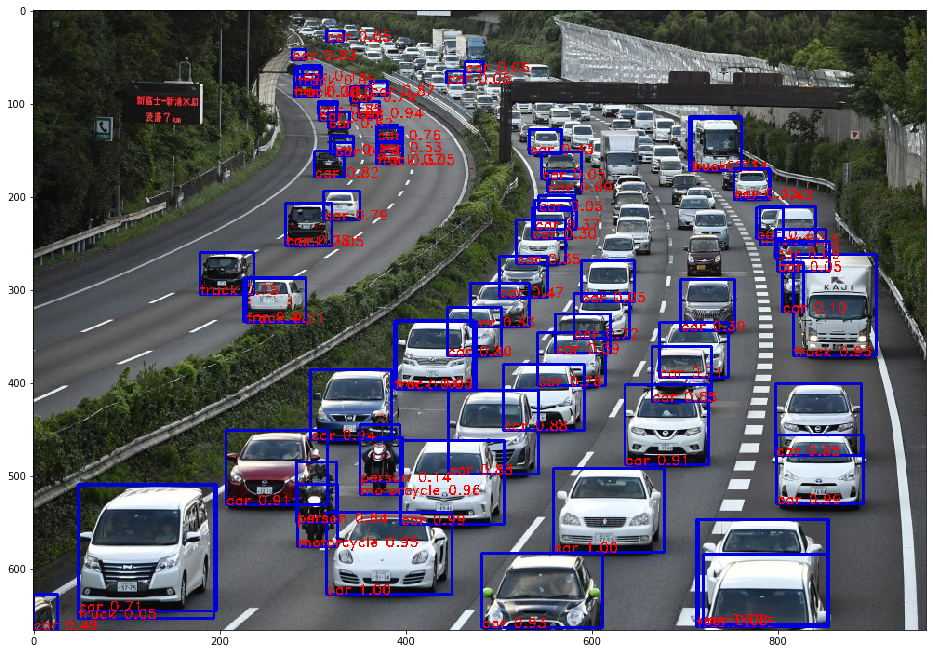

In [8]:
# Viz
fig = plt.figure(figsize=(16,16))
sample = cv2.imread(impath)
# rescale boxes to image size
boxes[:,0] *= sample.shape[1]
boxes[:,2] *= sample.shape[1]
boxes[:,1] *= sample.shape[0]
boxes[:,3] *= sample.shape[0]
for i, box in enumerate(boxes):
    cv2.rectangle(sample,
              (int(box[0]), int(box[1])),
              (int(box[2]), int(box[3])),
              220, 2)
    cv2.putText(sample, cococlass[labels[i]] + " {:.2f}".format(scores[i]), (int(box[0]), int(box[3])),  
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255), 1) # Write the prediction class

plt.imshow(sample[:,:,::-1])#BGR2RGB
plt.show()